In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import os
import tarfile
import shutil
import tempfile
import time
import pickle
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset, TciaDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    CropForegroundd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    ResampleToMatchd,
)
from monai.utils import set_determinism

import torch
import torch.nn.parallel
import torch.distributed as dist

print_config()

MONAI version: 1.2.0
Numpy version: 1.25.0
Pytorch version: 2.0.1+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: c:\Users\Cecilia\AppData\Local\pypoetry\Cache\virtualenvs\unsup-seg-gbm-nLgqUjZ0-py3.11\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
py

## Ejemplo Decatlon Dataset

In [18]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is necrosis
    label 2 is edema
    label 3 is activo
    The possible classes are N (necrosis), E (edema)
    and TA (active).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # label 1 necro
            result.append(d[key] == 1)
            # label 2 is ET
            result.append(d[key] == 2)
            # merge labels 3, 4 and 3 to construct activo
            result.append(torch.logical_or(d[key] == 3, d[key] == 4))

            d[key] = torch.stack(result, axis=0).float()
        return d

In [19]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"],allow_missing_keys=True),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

In [20]:
# here we don't cache any data in case out of memory issue
root_dir="./Dataset"
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
train_loader_ = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader_ = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)

In [21]:
val_ds[0]['image'].shape

torch.Size([4, 240, 240, 155])

In [22]:
cont=0
for batch_data in train_loader_:
    print(batch_data["image"].shape),
    print(batch_data["label"].shape),
    cont+=1
    if cont==2:
        break
    

torch.Size([1, 4, 224, 224, 144])
torch.Size([1, 3, 224, 224, 144])
torch.Size([1, 4, 224, 224, 144])
torch.Size([1, 3, 224, 224, 144])


## Con Dataset Personalizado

In [3]:
import os
from monai.data import Dataset, DataLoader
from monai.transforms import LoadImaged, Compose
from src.get_data import CustomDataset
import numpy as np
from scipy import ndimage

In [4]:
def fill_holes_3d(mask):
    # Rellenar huecos en la máscara 3D
    filled_mask = ndimage.binary_fill_holes(mask)
    return filled_mask

def expand_mask_3d_td(mask, edema, distance_cm_max=0.5, distance_cm_min=0.1, voxel_size=0.1):
  distance_pixels_max = int(distance_cm_max/ voxel_size)
  distance_pixel_min = int(distance_cm_min/voxel_size)

  # Calcular la transformada de distancia
  distance_transform = ndimage.distance_transform_edt(np.logical_not(mask))

  # Crear la nueva máscara alrededor del tumor core
  #expanded_mask_distance = distance_transform >= distance_threshold
  expanded_mask= np.logical_and(distance_transform >= distance_pixel_min, distance_transform <= distance_pixels_max)

  # Restar la máscara original para obtener solo la región expandida
  exterior_mask = np.logical_and(expanded_mask, np.logical_not(mask))
  # Hacer un AND con el edema para eliminar zonas externas a este
  exterior_mask = np.logical_and(exterior_mask, edema)

  return torch.from_numpy(exterior_mask)

In [30]:
class ConvertToMultiChannel_with_infiltration(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is necrosis
    label 2 is edema
    label 3 is activo
    The possible classes are N (necrosis), E (edema)
    and TA (active).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []

            # label 1 necro
            necro= d[key] == 1
            # result.append(necro)

            # label 2 is Edema
            edema = d[key] == 2
            #result.append(edema)

            # merge labels 3, 4 and 3 to construct activo
            active = torch.logical_or(d[key] == 3, d[key] == 4)
            #result.append(active)

            # Determinar las ROI cercana y lejana al Tumor Core
            tumor_core_mask = np.logical_or(necro, active)
                        
            # Rellenar los huecos en la máscara
            filled_tumor_core= fill_holes_3d(tumor_core_mask)
            #result.append(torch.from_numpy(filled_tumor_core))

            # Definir el tamaño de voxel en centímetros (ajusta según tus datos)
            voxel_size_cm = 0.1

            # Expandir la máscara de 1 cm alrededor del tumor core (N_ROI)
            N_roi = expand_mask_3d_td(filled_tumor_core, edema=edema,
                                      distance_cm_max=0.5, distance_cm_min=0.1,
                                      voxel_size=voxel_size_cm)   
            result.append(N_roi) 

            F_roi = expand_mask_3d_td(filled_tumor_core, edema=edema,
                                      distance_cm_max=10, distance_cm_min=1,
                                      voxel_size=voxel_size_cm)  
            result.append(F_roi) 
            result.append(edema) 

            d[key] = torch.stack(result, axis=0).float()
        return d

In [6]:
from monai.transforms import CropForegroundd

In [31]:
# Transformaciones
t_transform = Compose(
    [
        LoadImaged(keys=["image", "label"],allow_missing_keys=True),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannel_with_infiltration(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        CropForegroundd(keys=["image", "label"], source_key="label", margin=[112, 112, 72]),
        RandSpatialCropd(keys=["image", "label"], roi_size=[112, 112, 72], random_size=False), # [224, 224, 144]
        
    ]
)

v_transform = Compose(
    [
        LoadImaged(keys=["image", "label"],allow_missing_keys=True),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannel_with_infiltration(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

In [32]:
dataset_path='./Dataset/Dataset_30_casos/'

train_set=CustomDataset(dataset_path, section="train",transform=t_transform) # t_transform
train_loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)

im_t=train_set[0]
print(im_t['image'].shape)
print(im_t['label'].shape)


val_set=CustomDataset(dataset_path, section="valid", transform=v_transform) # v_transform
val_loader = DataLoader(val_set, batch_size=1, shuffle=False, num_workers=0)

im_v=val_set[0]
print(im_v['image'].shape)
print(im_v['label'].shape)

Found 30 images and 30 labels.
torch.Size([11, 112, 112, 72])
torch.Size([3, 112, 112, 72])
Found 10 images and 10 labels.
torch.Size([11, 240, 240, 155])
torch.Size([3, 240, 240, 155])


In [29]:
for batch_data in train_loader:
    print(batch_data["image"].shape),
    print(batch_data["label"].shape),
    
    break
            

torch.Size([1, 11, 112, 112, 72])
torch.Size([1, 2, 112, 112, 72])


image shape: torch.Size([11, 112, 112, 72])


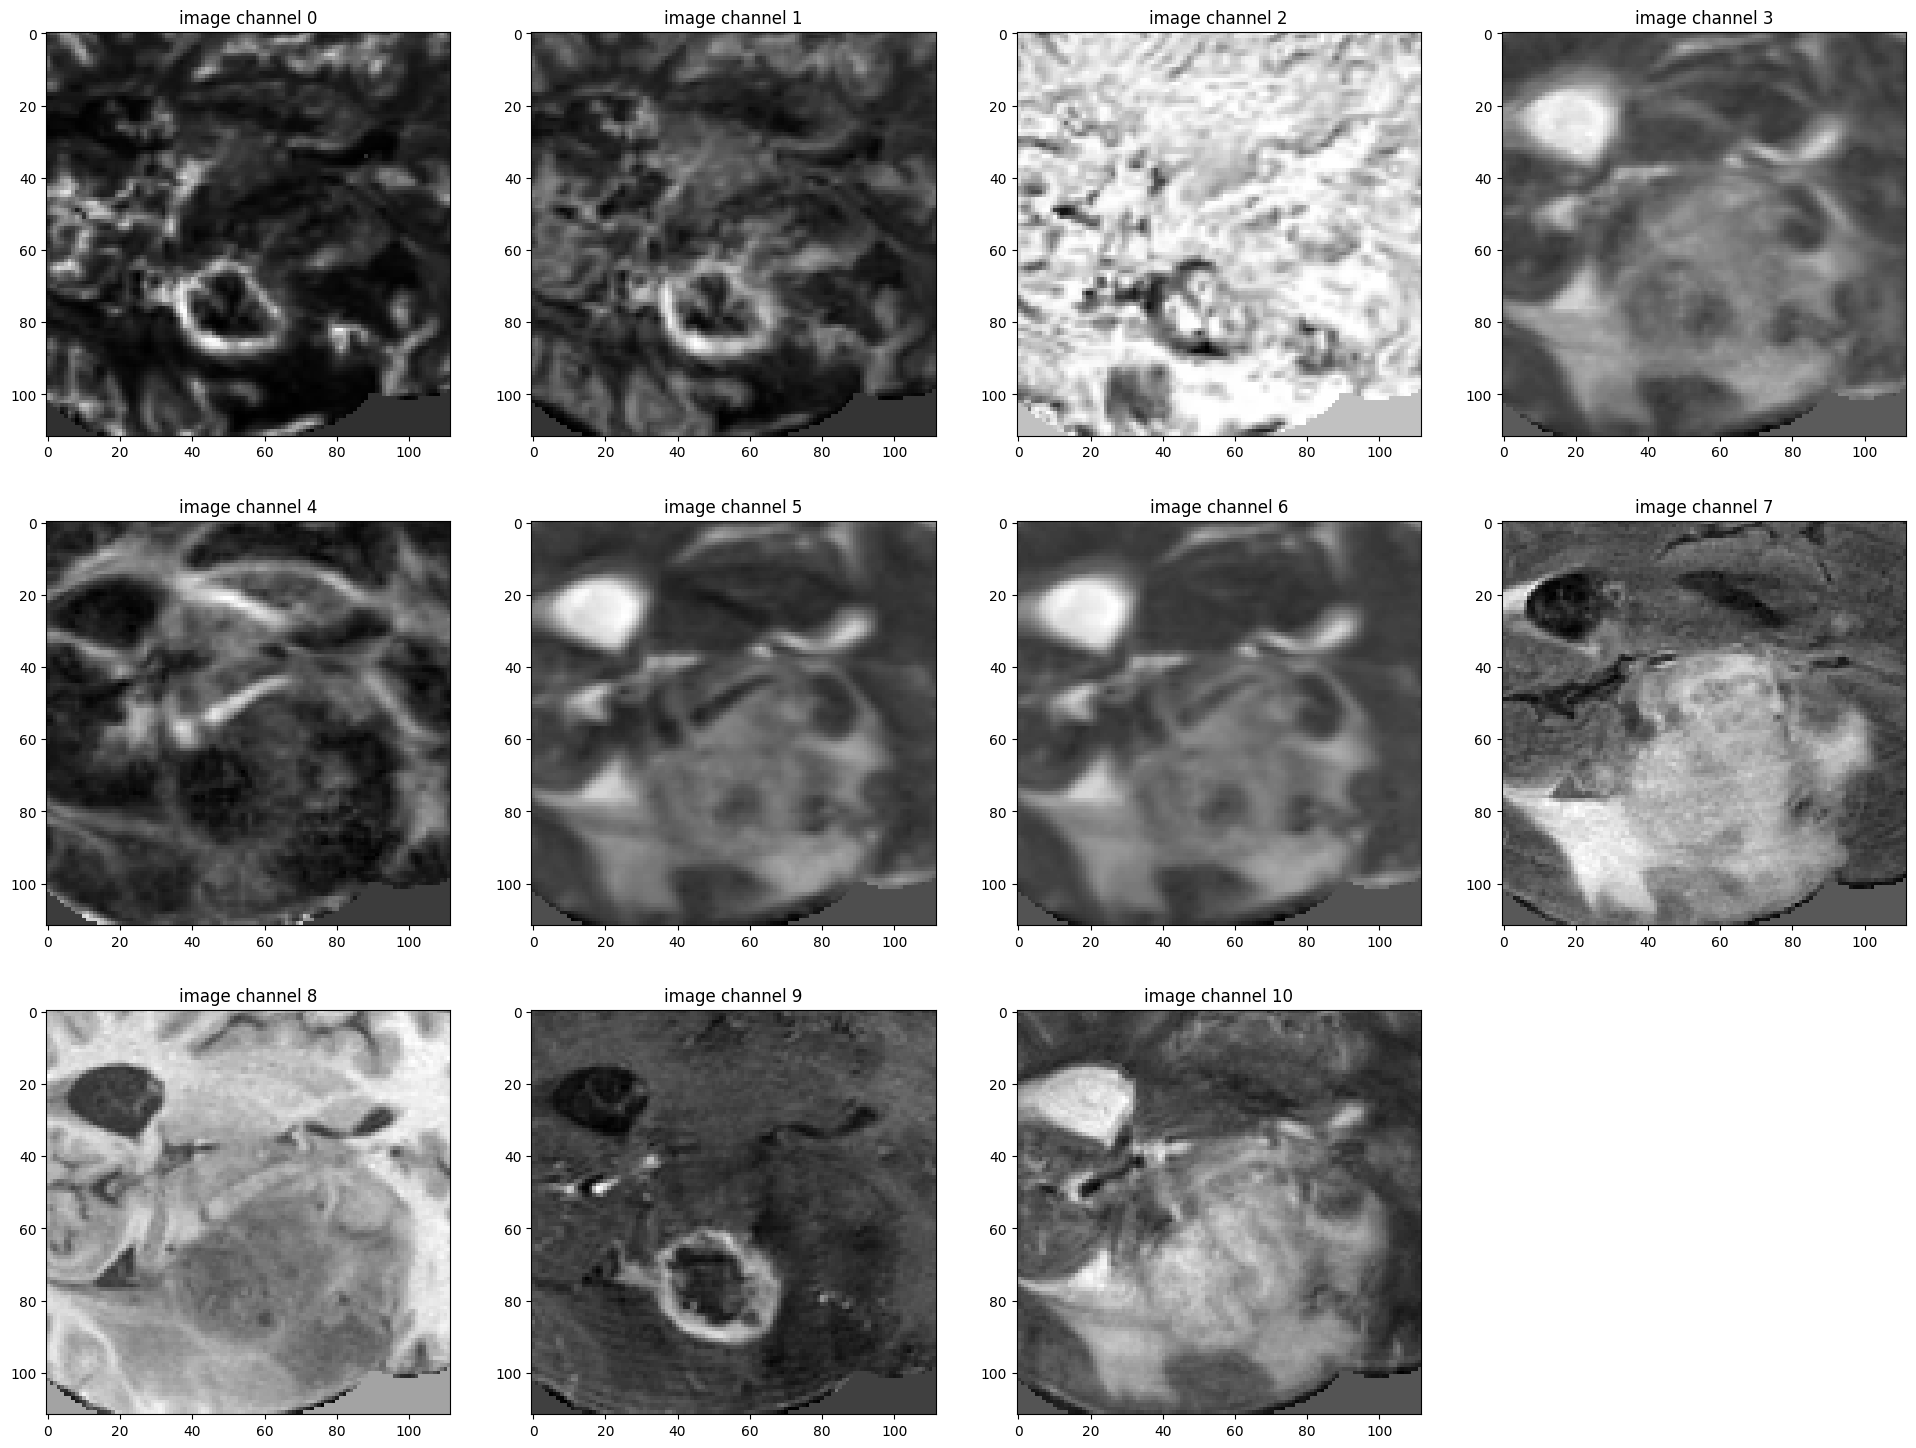

label shape: torch.Size([3, 112, 112, 72])


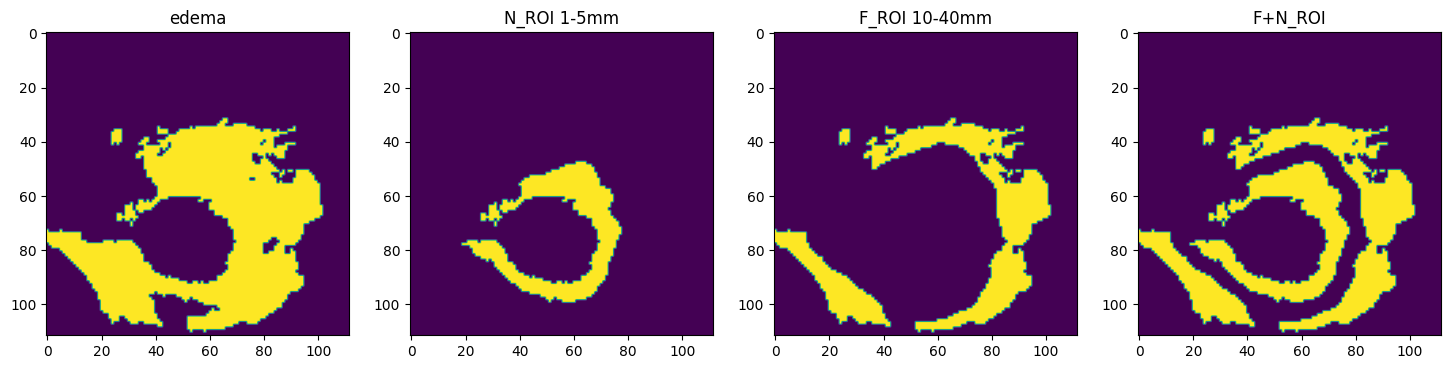

In [22]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
# N_ROI -> hatsa 0.5cm alrededor del TC
# F_ROI -> entre 1 y 4 cm alrededor del TC
val_data_example = train_set[0]
sl=36 #70
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 18))
for i in range(11):
    plt.subplot(3, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, sl].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
my_title=['edema','N_ROI 1-5mm', 'F_ROI 10-40mm', 'F+N_ROI']
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"{my_title[i]}")
    if i<3:
        plt.imshow(val_data_example["label"][i, :, :, sl].detach().cpu())
    else:
        im_show=torch.from_numpy(np.logical_or(val_data_example["label"][2, :, :, sl], val_data_example["label"][1, :, :, sl]))
        plt.imshow((im_show).detach().cpu())

plt.show()

# Prueba de entrenamiento

In [205]:
from types import SimpleNamespace
import logging

logging.basicConfig(level=logging.INFO)

#logging.info(print_config())

In [206]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# DATA_DIR = Path('./data/')
SAVE_DIR = "./Dataset"
# SAVE_DIR.mkdir(exist_ok=True, parents=True)
DEVICE = device

# HIPER PARAMETER CONFIGURATION
config_train = SimpleNamespace(
    # network hyperparameters
    init_filters=16,
    dropout_prob=0.2,
    # training hyperparameters
    max_epochs=10,
    lrate=1e-4,
    weight_decay=1e-5,
    batch_size=1,
    # Post
    threshold=0.5,
    # Train type
    use_scaler=False,
    use_autocast=False,
)

def inference(input, model, VAL_AMP=config_train.use_autocast):
        # if config_train.use_autocast:
        #    VAL_AMP = True
        # else:
        #    VAL_AMP = False

        def _compute(input):
            return sliding_window_inference(
                inputs=input,
                roi_size=(240, 240, 160),
                sw_batch_size=1,
                predictor=model,
                overlap=0.5,
            )

        if VAL_AMP:
            with torch.cuda.amp.autocast():
                return _compute(input)
        else:
            return _compute(input)

## Creating model

In [207]:
 # standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
model = SegResNet(
        blocks_down=[1, 2, 2, 4], #4
        blocks_up=[1, 1, 1],
        init_filters=16,
        in_channels=11,
        out_channels=3,
        dropout_prob=config_train.dropout_prob,
    )

model.to(device)

loss_function = DiceLoss(
        smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True
    )
optimizer = torch.optim.Adam(
        model.parameters(), config_train.lrate, weight_decay=config_train.weight_decay
    )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=config_train.max_epochs
    )

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose(
        [Activations(sigmoid=True), AsDiscrete(threshold=config_train.threshold)]
    )

    # use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
    # enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

c:\Users\Cecilia\AppData\Local\pypoetry\Cache\virtualenvs\unsup-seg-gbm-nLgqUjZ0-py3.11\Lib\site-packages\torch\cuda\amp\grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [208]:
#best_metric = 1
#epoch_loss_values = []
val_interval = 1
max_epochs = config_train.max_epochs

best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
        torch.cuda.empty_cache()
        epoch_start = time.time()
        logging.info("-" * 10)
        logging.info(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step_start = time.time()
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()

            if config_train.use_scaler:
                # with autocast
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # without autocast
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()

            epoch_loss += loss.item()
            logging.info(
                f"{step}/{len(train_set) // train_loader.batch_size}"
                f", train_loss: {loss.item():.4f}"
                f", step time: {(time.time() - step_start):.4f}"
            )

        lr_scheduler.step()
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        logging.info(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        # Evaluar en validación
        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    val_outputs = inference(val_inputs, model)
                    val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                    dice_metric(y_pred=val_outputs, y=val_labels)
                    dice_metric_batch(y_pred=val_outputs, y=val_labels)

                metric = dice_metric.aggregate().item()
                metric_values.append(metric)
                metric_batch = dice_metric_batch.aggregate()
                metric_tc = metric_batch[0].item()
                metric_values_tc.append(metric_tc)
                metric_wt = metric_batch[1].item()
                metric_values_wt.append(metric_wt)
                metric_et = metric_batch[2].item()
                metric_values_et.append(metric_et)
                dice_metric.reset()
                dice_metric_batch.reset()

                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    best_metrics_epochs_and_time[0].append(best_metric)
                    best_metrics_epochs_and_time[1].append(best_metric_epoch)
                    best_metrics_epochs_and_time[2].append(time.time() - total_start)
                    torch.save(
                        model.state_dict(),
                        os.path.join(SAVE_DIR, "best_metric_model.pth"),
                    )
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f" Necro: {metric_tc:.4f} Edema: {metric_wt:.4f} TA: {metric_et:.4f}"
                    f"\nbest mean dice: {best_metric:.4f}"
                    f" at epoch: {best_metric_epoch}"
                )
        print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start



INFO:root:----------
INFO:root:epoch 1/10
INFO:root:1/10, train_loss: 0.9901, step time: 4.2900
INFO:root:2/10, train_loss: 0.8861, step time: 4.7290
INFO:root:3/10, train_loss: 0.9110, step time: 4.3953
INFO:root:4/10, train_loss: 0.9662, step time: 4.2931
INFO:root:5/10, train_loss: 0.9671, step time: 4.3477
INFO:root:6/10, train_loss: 0.9885, step time: 4.3787
INFO:root:7/10, train_loss: 0.8318, step time: 4.4614
INFO:root:8/10, train_loss: 0.9822, step time: 4.3927
INFO:root:9/10, train_loss: 1.0000, step time: 4.4551
INFO:root:10/10, train_loss: 0.9832, step time: 4.4721
INFO:root:epoch 1 average loss: 0.9506
INFO:root:----------
INFO:root:epoch 2/10


saved new best metric model
current epoch: 1 current mean dice: 0.1293 Necro: 0.3744 Edema: 0.0038 TA: 0.0097
best mean dice: 0.1293 at epoch: 1
time consuming of epoch 1 is: 116.6979


INFO:root:1/10, train_loss: 0.9888, step time: 4.5342
INFO:root:2/10, train_loss: 0.7295, step time: 4.5381
INFO:root:3/10, train_loss: 0.9996, step time: 4.6979
INFO:root:4/10, train_loss: 0.9304, step time: 4.7925
INFO:root:5/10, train_loss: 0.8822, step time: 4.8346
INFO:root:6/10, train_loss: 0.9990, step time: 4.8609
INFO:root:7/10, train_loss: 0.9981, step time: 4.8691
INFO:root:8/10, train_loss: 0.9853, step time: 4.7886
INFO:root:9/10, train_loss: 0.9199, step time: 6.1801
INFO:root:10/10, train_loss: 0.9977, step time: 4.6432
INFO:root:epoch 2 average loss: 0.9430
INFO:root:----------
INFO:root:epoch 3/10


saved new best metric model
current epoch: 2 current mean dice: 0.1753 Necro: 0.5108 Edema: 0.0040 TA: 0.0110
best mean dice: 0.1753 at epoch: 2
time consuming of epoch 2 is: 123.0484


INFO:root:1/10, train_loss: 0.9550, step time: 4.6199
INFO:root:2/10, train_loss: 0.7189, step time: 4.5462
INFO:root:3/10, train_loss: 0.8158, step time: 4.5874
INFO:root:4/10, train_loss: 0.9334, step time: 4.5428
INFO:root:5/10, train_loss: 1.0000, step time: 4.5276
INFO:root:6/10, train_loss: 0.9632, step time: 4.5683
INFO:root:7/10, train_loss: 0.8203, step time: 4.5295
INFO:root:8/10, train_loss: 0.8903, step time: 4.5530
INFO:root:9/10, train_loss: 0.8863, step time: 4.5269
INFO:root:10/10, train_loss: 0.9534, step time: 4.4657
INFO:root:epoch 3 average loss: 0.8937
INFO:root:----------
INFO:root:epoch 4/10


saved new best metric model
current epoch: 3 current mean dice: 0.1940 Necro: 0.5681 Edema: 0.0040 TA: 0.0098
best mean dice: 0.1940 at epoch: 3
time consuming of epoch 3 is: 119.0657


INFO:root:1/10, train_loss: 0.9116, step time: 4.5644
INFO:root:2/10, train_loss: 0.8004, step time: 4.6195
INFO:root:3/10, train_loss: 0.8491, step time: 4.5645
INFO:root:4/10, train_loss: 0.8770, step time: 4.5654
INFO:root:5/10, train_loss: 0.9639, step time: 4.5172
INFO:root:6/10, train_loss: 0.9312, step time: 4.6141
INFO:root:7/10, train_loss: 0.9984, step time: 4.6361
INFO:root:8/10, train_loss: 0.9976, step time: 4.5993
INFO:root:9/10, train_loss: 0.9546, step time: 4.7543
INFO:root:10/10, train_loss: 0.8981, step time: 4.4777
INFO:root:epoch 4 average loss: 0.9182
INFO:root:----------
INFO:root:epoch 5/10


saved new best metric model
current epoch: 4 current mean dice: 0.2238 Necro: 0.6578 Edema: 0.0040 TA: 0.0097
best mean dice: 0.2238 at epoch: 4
time consuming of epoch 4 is: 119.9320


INFO:root:1/10, train_loss: 0.9296, step time: 4.5260
INFO:root:2/10, train_loss: 0.8315, step time: 4.4257
INFO:root:3/10, train_loss: 0.8008, step time: 4.4886
INFO:root:4/10, train_loss: 0.9520, step time: 4.6648
INFO:root:5/10, train_loss: 0.7881, step time: 4.6574
INFO:root:6/10, train_loss: 0.8134, step time: 4.6598
INFO:root:7/10, train_loss: 0.9424, step time: 4.5054
INFO:root:8/10, train_loss: 0.8609, step time: 4.4556
INFO:root:9/10, train_loss: 0.9297, step time: 4.6048
INFO:root:10/10, train_loss: 0.9161, step time: 4.6441
INFO:root:epoch 5 average loss: 0.8764
INFO:root:----------
INFO:root:epoch 6/10


current epoch: 5 current mean dice: 0.2100 Necro: 0.6164 Edema: 0.0040 TA: 0.0097
best mean dice: 0.2238 at epoch: 4
time consuming of epoch 5 is: 119.2597


INFO:root:1/10, train_loss: 0.9862, step time: 4.5155
INFO:root:2/10, train_loss: 0.8207, step time: 4.4255
INFO:root:3/10, train_loss: 0.9202, step time: 4.5614
INFO:root:4/10, train_loss: 0.9367, step time: 4.5013
INFO:root:5/10, train_loss: 0.9915, step time: 4.4700
INFO:root:6/10, train_loss: 0.9973, step time: 4.5967
INFO:root:7/10, train_loss: 0.8821, step time: 4.4689
INFO:root:8/10, train_loss: 0.9803, step time: 4.5123
INFO:root:9/10, train_loss: 0.9373, step time: 4.6290
INFO:root:10/10, train_loss: 0.9699, step time: 4.5352
INFO:root:epoch 6 average loss: 0.9422
INFO:root:----------
INFO:root:epoch 7/10


saved new best metric model
current epoch: 6 current mean dice: 0.2397 Necro: 0.7054 Edema: 0.0040 TA: 0.0097
best mean dice: 0.2397 at epoch: 6
time consuming of epoch 6 is: 118.7180


INFO:root:1/10, train_loss: 0.9966, step time: 4.4299
INFO:root:2/10, train_loss: 0.7568, step time: 4.5649
INFO:root:3/10, train_loss: 0.9435, step time: 5.0868
INFO:root:4/10, train_loss: 0.9490, step time: 4.6829
INFO:root:5/10, train_loss: 0.9001, step time: 4.4326
INFO:root:6/10, train_loss: 0.8859, step time: 4.5027
INFO:root:7/10, train_loss: 0.7596, step time: 4.5734
INFO:root:8/10, train_loss: 0.8749, step time: 5.0538
INFO:root:9/10, train_loss: 0.7150, step time: 5.0213
INFO:root:10/10, train_loss: 0.9931, step time: 4.5802
INFO:root:epoch 7 average loss: 0.8774
INFO:root:----------
INFO:root:epoch 8/10


current epoch: 7 current mean dice: 0.2280 Necro: 0.6702 Edema: 0.0040 TA: 0.0097
best mean dice: 0.2397 at epoch: 6
time consuming of epoch 7 is: 126.4304


INFO:root:1/10, train_loss: 0.9164, step time: 6.2165
INFO:root:2/10, train_loss: 0.7628, step time: 5.8130
INFO:root:3/10, train_loss: 0.9140, step time: 5.6198
INFO:root:4/10, train_loss: 0.9460, step time: 5.9082
INFO:root:5/10, train_loss: 0.9997, step time: 5.0405
INFO:root:6/10, train_loss: 0.9237, step time: 4.9509
INFO:root:7/10, train_loss: 0.8025, step time: 5.1071
INFO:root:8/10, train_loss: 0.9072, step time: 5.1406
INFO:root:9/10, train_loss: 0.9208, step time: 5.1738
INFO:root:10/10, train_loss: 0.9998, step time: 5.1809
INFO:root:epoch 8 average loss: 0.9093
INFO:root:----------
INFO:root:epoch 9/10


current epoch: 8 current mean dice: 0.2267 Necro: 0.6664 Edema: 0.0040 TA: 0.0097
best mean dice: 0.2397 at epoch: 6
time consuming of epoch 8 is: 136.6643


INFO:root:1/10, train_loss: 0.9287, step time: 5.1360
INFO:root:2/10, train_loss: 0.6594, step time: 4.9596
INFO:root:3/10, train_loss: 0.7986, step time: 4.6213
INFO:root:4/10, train_loss: 0.9131, step time: 4.4733
INFO:root:5/10, train_loss: 0.9999, step time: 4.5881
INFO:root:6/10, train_loss: 0.9988, step time: 4.6654
INFO:root:7/10, train_loss: 0.9576, step time: 5.0415
INFO:root:8/10, train_loss: 1.0000, step time: 4.6331
INFO:root:9/10, train_loss: 0.8638, step time: 4.5740
INFO:root:10/10, train_loss: 0.9911, step time: 4.5749
INFO:root:epoch 9 average loss: 0.9111
INFO:root:----------
INFO:root:epoch 10/10


current epoch: 9 current mean dice: 0.2305 Necro: 0.6777 Edema: 0.0040 TA: 0.0097
best mean dice: 0.2397 at epoch: 6
time consuming of epoch 9 is: 122.1848


INFO:root:1/10, train_loss: 0.9737, step time: 4.4833
INFO:root:2/10, train_loss: 0.7044, step time: 4.4865
INFO:root:3/10, train_loss: 0.9321, step time: 4.6989
INFO:root:4/10, train_loss: 0.9570, step time: 4.4935
INFO:root:5/10, train_loss: 0.9951, step time: 4.5558
INFO:root:6/10, train_loss: 0.7893, step time: 4.5247
INFO:root:7/10, train_loss: 0.7567, step time: 4.5342
INFO:root:8/10, train_loss: 0.9491, step time: 4.5026
INFO:root:9/10, train_loss: 0.7269, step time: 4.5862
INFO:root:10/10, train_loss: 1.0000, step time: 4.4636
INFO:root:epoch 10 average loss: 0.8784


current epoch: 10 current mean dice: 0.2309 Necro: 0.6790 Edema: 0.0040 TA: 0.0097
best mean dice: 0.2397 at epoch: 6
time consuming of epoch 10 is: 118.7301
